### This notebook looks at a lot of descriptive statistics of our dataset.

It includes:
- overall probability of female / male first authorship (0.2777 / 0.7223)
- overall probability of female / male last authorship (0.1915 / 0.8085)
- overall probability of female / male coauthorship [not first or last] (0.2346 / 0.7654)
- overall probability of female / male authorship in any position (0.2356 / 0.7645)


- Probability of having at least one female / male author in an article 0.5866 / 0.9733
- Probability of having all female / male authors in an article 0.0267 / 0.4134


- Average number of authors for articles 4.2


Next, it checks how high the probability is to have at least 1 female author depending on the overall occurrence of female authors and the number of authors per paper, using the formula that having all male authors of one paper is Pmale^nr.authors. This formula gives the expected probability, which we can use to compute biases in observed probabilites (computed from data). This reveals:
- Men are overrepresented as single authors, and women are thus underrepresented (6.5% bias).
- Based on the average rate of male / female representation, it is very unlikely to have an all-female authorship team (p = 0.0267, approx. every one out of 50 articles), whereas it is very common to have an all-male authorship team (p = 0.4134, approx. every 2 out of 5 articles).
- There appears to be a slight gender segregation effect, i.e. men tend to publish in all-male authorship groups more than expected from the average female-male distribution. Consequently, there is a negative bias towards having female coauthors or collaborators (3% for articles with 5 or less authors).  

We then test this comparison of expected vs. observed when it comes to having at least one female / male author per publication, separated by journal. We do the same for first and last authorship. The main results are (we still need to work more on this):
- The probability of having at least 1 female author is significantly and strongly correlated to the median number of authors in journal publications (Pearson corr, r = 0.8, p < 0.001). For men, this is not significant (p = 0.1), but it is significant with respect to the impact factor of the journal (spearman corr, r = 0.71, p = 0.005) (not significant for women (p = 0.3)).
- In Science is almost 10% more probable to be a coauthor than a first or last author for a female seismologist.
- Nature and Geophysics are always below expected probabilities for first, co-, and last female authorship.

Next, we explore the prob. of male / female authorship per year. 
- we find an increase rate around 0.271 per year for first and last authorship. Simply waiting for parity would take a long time (~80-90 years).
- For the coauthorship, the increase rate is almost twice larger (0.56 %, equality in ~40 years)
- Number of authors per publication is increasing with years. This also increases the probability of having at least 1 female and male authors. In 30 years, female authors will appear in 98% of the publications, which is approx. the current representation for male authors.




In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import numpy as np
import json

import os

from read_jsondata import read_jsons

import time

## Hypotheses to be tested

#### As reference values to compare to, we will use demographics from ECS from AGU and EGU. This will give an idea of how many of the active scientists at these professional levels are represented to the peer-reviewed articles (which is the main crucial factor for career advancing and perhaps the daily goal of most academics)

FIRST GLANCES AT DATA

- % of female first authors (hists?)
- % publications with all male vs. % publications with all female authors (hists?)

CO-AUTHORSHIP ANALYSES

- When 1st author is female: % of male vs. female co-authors (bars..?)
- When 1st author is female: likelihood of last author (possibly PI) to be female vs. male 
- When 1st author is male: % of female coauthors and % of male coauthors
- When the last name is female (possible PI), is there a higher % of female co-authors vs. male ones?

JOURNAL IF ANALYSES:

- Correlation between IF and female first authors: does higher IF mean fewer female first authors?




In [2]:
# Define local paths

root = ! pwd
root = root[0]

RAW_DIR=root+"/author_allgenders/"  

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

In [5]:
df = read_jsons(RAW_DIR)  # included here cleanup and IF and removing 2021
df

,year,journal,all_genders,all_percent,IF
0,2015,BSSA,"[male, male, male, male, female, male, male, m...","[0.99, 0.98, 0.99, 0.99, 0.95, 0.99, 0.93, 0.9...",2.274
1,2013,GJI,"[female, male, male, male]","[0.98, 0.98, 0.99, 0.98]",2.834
2,2019,GEOPHYSICS,"[male, male, male]","[0.99, 0.99, 0.94]",3.093
3,2016,GRL,"[female, male, male, male, male, male, male, m...","[0.5019126929602223, 0.85, 1.0, 0.85, 0.636418...",4.952
4,2013,JGRSolidEarth,"[male, male, female, female, male]","[0.99, 0.9, 0.98, 0.98, 0.97]",4.191
...,...,...,...,...,...
20103,2010,BSSA,"[female, female, female, male, female, female]","[0.99, 0.99, 0.99, 1.0, 0.99, 0.99]",2.274
20104,2020,PEPI,"[male, male]","[0.98, 0.99]",2.413
20105,2016,GJI,"[male, male, male, male]","[0.99, 1.0, 0.9, 0.99]",2.834
20106,2015,BSSA,"[female, male]","[1.0, 0.94]",2.274


### Create new columns in the dataframe extracting useful information from list of coauthors

In [6]:
# Number of authors:

df['Number_authors'] = df['all_genders'].apply(lambda x: len(x)) #take the length of the list all_genders
df['Number_init'] = df['all_genders'].apply(lambda x: len([s for s in x if "init"==s]))


# First author's gender and percentage:

df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_perc'] = df['all_percent'].apply(lambda x: x[0])

# Last author's gender and percentage:

df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_perc'] = df['all_percent'].apply(lambda x: x[-1])

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,2015,BSSA,"[male, male, male, male, female, male, male, m...","[0.99, 0.98, 0.99, 0.99, 0.95, 0.99, 0.93, 0.9...",2.274,18,0,male,0.990000,female,0.62
1,2013,GJI,"[female, male, male, male]","[0.98, 0.98, 0.99, 0.98]",2.834,4,0,female,0.980000,male,0.98
2,2019,GEOPHYSICS,"[male, male, male]","[0.99, 0.99, 0.94]",3.093,3,0,male,0.990000,male,0.94
3,2016,GRL,"[female, male, male, male, male, male, male, m...","[0.5019126929602223, 0.85, 1.0, 0.85, 0.636418...",4.952,11,0,female,0.501913,male,0.93
4,2013,JGRSolidEarth,"[male, male, female, female, male]","[0.99, 0.9, 0.98, 0.98, 0.97]",4.191,5,0,male,0.990000,male,0.97
...,...,...,...,...,...,...,...,...,...,...,...
20103,2010,BSSA,"[female, female, female, male, female, female]","[0.99, 0.99, 0.99, 1.0, 0.99, 0.99]",2.274,6,0,female,0.990000,female,0.99
20104,2020,PEPI,"[male, male]","[0.98, 0.99]",2.413,2,0,male,0.980000,male,0.99
20105,2016,GJI,"[male, male, male, male]","[0.99, 1.0, 0.9, 0.99]",2.834,4,0,male,0.990000,male,0.99
20106,2015,BSSA,"[female, male]","[1.0, 0.94]",2.274,2,0,female,1.000000,male,0.94


### Dropping init (unidentified initialed names)

In [7]:
df = df[df.Number_init==0].copy()
df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,2015,BSSA,"[male, male, male, male, female, male, male, m...","[0.99, 0.98, 0.99, 0.99, 0.95, 0.99, 0.93, 0.9...",2.274,18,0,male,0.990000,female,0.62
1,2013,GJI,"[female, male, male, male]","[0.98, 0.98, 0.99, 0.98]",2.834,4,0,female,0.980000,male,0.98
2,2019,GEOPHYSICS,"[male, male, male]","[0.99, 0.99, 0.94]",3.093,3,0,male,0.990000,male,0.94
3,2016,GRL,"[female, male, male, male, male, male, male, m...","[0.5019126929602223, 0.85, 1.0, 0.85, 0.636418...",4.952,11,0,female,0.501913,male,0.93
4,2013,JGRSolidEarth,"[male, male, female, female, male]","[0.99, 0.9, 0.98, 0.98, 0.97]",4.191,5,0,male,0.990000,male,0.97
...,...,...,...,...,...,...,...,...,...,...,...
20103,2010,BSSA,"[female, female, female, male, female, female]","[0.99, 0.99, 0.99, 1.0, 0.99, 0.99]",2.274,6,0,female,0.990000,female,0.99
20104,2020,PEPI,"[male, male]","[0.98, 0.99]",2.413,2,0,male,0.980000,male,0.99
20105,2016,GJI,"[male, male, male, male]","[0.99, 1.0, 0.9, 0.99]",2.834,4,0,male,0.990000,male,0.99
20106,2015,BSSA,"[female, male]","[1.0, 0.94]",2.274,2,0,female,1.000000,male,0.94


 #### It is easier if the all probabilities are with respect to the same gender (female)

In [8]:
# prob(female) = 1 - prob(male)

# Prob last author female:

df['Last_Author_probF'] = df['Last_Author_perc'] #initialize the new column
df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF']

# Prob first author female:

df['First_Author_probF'] = df['First_Author_perc'] #initialize the new column
df.loc[df['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df.loc[df['First_Author_gend'] == 'male','First_Author_probF']

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,2015,BSSA,"[male, male, male, male, female, male, male, m...","[0.99, 0.98, 0.99, 0.99, 0.95, 0.99, 0.93, 0.9...",2.274,18,0,male,0.990000,female,0.62,0.62,0.010000
1,2013,GJI,"[female, male, male, male]","[0.98, 0.98, 0.99, 0.98]",2.834,4,0,female,0.980000,male,0.98,0.02,0.980000
2,2019,GEOPHYSICS,"[male, male, male]","[0.99, 0.99, 0.94]",3.093,3,0,male,0.990000,male,0.94,0.06,0.010000
3,2016,GRL,"[female, male, male, male, male, male, male, m...","[0.5019126929602223, 0.85, 1.0, 0.85, 0.636418...",4.952,11,0,female,0.501913,male,0.93,0.07,0.501913
4,2013,JGRSolidEarth,"[male, male, female, female, male]","[0.99, 0.9, 0.98, 0.98, 0.97]",4.191,5,0,male,0.990000,male,0.97,0.03,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20103,2010,BSSA,"[female, female, female, male, female, female]","[0.99, 0.99, 0.99, 1.0, 0.99, 0.99]",2.274,6,0,female,0.990000,female,0.99,0.99,0.990000
20104,2020,PEPI,"[male, male]","[0.98, 0.99]",2.413,2,0,male,0.980000,male,0.99,0.01,0.020000
20105,2016,GJI,"[male, male, male, male]","[0.99, 1.0, 0.9, 0.99]",2.834,4,0,male,0.990000,male,0.99,0.01,0.010000
20106,2015,BSSA,"[female, male]","[1.0, 0.94]",2.274,2,0,female,1.000000,male,0.94,0.06,1.000000


## Now we can compute some interesting probabilities:

### Useful formulas:

Suppose $x_i$ refers to the article $i$ and $N$ is the total number of articles. Then, the probability of an article having female author is (the law of total probability):

$$p(\text{female}) = \sum_{i}^N p(\text{female}|x_i) p(x_i). $$

If we have all the probabilities with respect to the female gender, then the probability of having a male author will be:

$$p(\text{male}) = \sum_{i}^N (1 - p(\text{female}|x_i)) p(x_i). $$

$p(x_i)$ is the probability of the article $x_i$. All articles have the same probability, therefore $p(x_i) = \frac{1}{N}$. This means that the formulas above are same as taking the average of  $p(\text{female}|x_i)$ or $(1 - p(\text{female}|x_i))$, respectively.


### Let's compute some easy statistics to start

In [9]:
p_ff = df['First_Author_probF'].sum()/df.shape[0]
p_mf = (1 - df['First_Author_probF']).sum()/df.shape[0]
p_fl = df['Last_Author_probF'].sum()/df.shape[0]
p_ml = (1 - df['Last_Author_probF']).sum()/df.shape[0]


print('Probability of having a female first author:', p_ff)
print('Probability of having a male first author:', p_mf)

print('Probability of having a female last author:', p_fl)
print('Probability of having a male last author:', p_ml)



Probability of having a female first author: 0.27766384428051777
Probability of having a male first author: 0.7223361557194823
Probability of having a female last author: 0.1915156652580671
Probability of having a male last author: 0.808484334741933


#### Overall probability of female or male authorship

In [10]:
def Prob_author(x,y, kind="female"):
    sum = 0
    for i,elem in enumerate(x):
        if elem != kind:
            sum += 1 - float(y[i]) 
        elif elem == kind:
            sum += float(y[i])
    return sum


# 1) determine overall frequencies
#==================================
# How many authors in total?
n_authors_all =df.Number_authors.sum()

# Sum of probability of female / total nr. 
p_female_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / n_authors_all

# Sum of probability of male / total nr.
p_male_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="male"), axis=1).sum() / n_authors_all

#==================================



# Now print some info; Check it adds to 1
#==================================
print("All probabilities sum: ", p_female_all + p_male_all)
print("Overall P of female authorship: ", p_female_all)
print("Overall P of male authorship: ", p_male_all)



All probabilities sum:  1.0000260420057552
Overall P of female authorship:  0.23556624884874175
Overall P of male authorship:  0.7644597931570135


#### Overall probability of female or male coauthorship [not first or last]

In [11]:
def Prob_coauthor(x,y, kind="female"):
    sum = 0
    for i,elem in enumerate(x):
        if i == 0 or i==len(x)-1:
            continue
        if elem != kind:
            sum += 1 - float(y[i]) 
        elif elem == kind:
            sum += float(y[i])
    return sum


# 1) determine overall probabilities of coauthors (not first and not last)
#======================================================================
df_co = df[df.Number_authors>2].copy()

n_coauthors =df_co.Number_authors.sum() - 2*df_co.shape[0]

# Sum of probability of female / total nr. 
p_female_all_co = df_co.apply(lambda x: Prob_coauthor(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / n_coauthors

# Sum of probability of male / total nr.
p_male_all_co = df_co.apply(lambda x: Prob_coauthor(x.all_genders, x.all_percent, kind="male"), axis=1).sum() / n_coauthors

#==================================



# Now print some info; Check it adds to 1
#==================================
print("All probabilities sum: ", p_female_all_co + p_male_all_co)
print("Overall P of female coauthorship: ", p_female_all_co)
print("Overall P of male coauthorship: ", p_male_all_co)



All probabilities sum:  1.0
Overall P of female coauthorship:  0.2346224253057474
Overall P of male coauthorship:  0.7653775746942526


#### Make bar plot with all previous descriptive probabilities

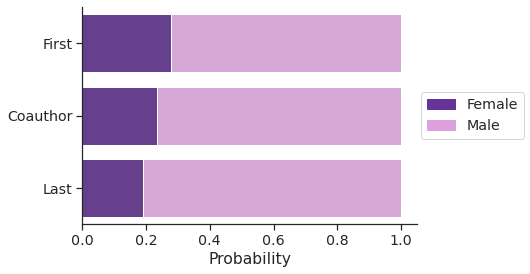

In [13]:
import matplotlib.patches as mpatches

sns.set(style="ticks")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})




data = {'Prob': [p_ff, p_female_all_co, p_fl, p_mf, p_male_all_co, p_ml], 
        'Gender': ['Female', 'Female', 'Female', 'Male', 'Male', 'Male'],
       'Pos': ['First', 'Coauthor','Last','First', 'Coauthor','Last']}


df_plot = pd.DataFrame(data=data)

ax = bar1 = sns.barplot(y="Pos",  x="Prob", data=df_plot,  estimator=sum,ci = None, color='plum', #color='darkorange'
                        dodge = False)
bar2 = sns.barplot(y="Pos", x="Prob", data=df_plot[df_plot.Gender == 'Female'], ci=None,  color='rebeccapurple',dodge = False)

top_bar = mpatches.Patch(color='plum', label='Male')
bottom_bar = mpatches.Patch(color='rebeccapurple', label='Female')
plt.legend(handles=[ bottom_bar, top_bar], bbox_to_anchor=(0.99, 0.64),
          ncol=1, fancybox=True, shadow=False)

#ax.axvline(0.2347, ls=':', color = 'olive', lw = '2.')

ax.set(xlabel='Probability', ylabel='')
sns.despine()

plt.savefig('./Figures/descriptive_stats_seaborn.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/descriptive_stats_seaborn.png',dpi = 300, bbox_inches="tight")

#### Probabilities of having at least one male/female author in an article

Having at least one female author refers to any coauthor combination excluding the case in which all authors are male:

$$p(\text{at least 1 female}|x_i) = 1 - p(\text{all male}|x_i)$$

Computing probability for all male coauthors is easier. In the following, we drop the dependency on $x_i$ for clarity.

$$p(\text{all male}) = p(\text{male}_1)p(\text{male}_2|\text{male}_1)p(\text{male}_3|\text{male}_1,\text{male}_2)... = \prod_i^n p(\text{male}_i)$$

where n is the number of authors and the last step assumes that the gender probability of each authorship is independent of the gender of other coauthors (just to simplify the problem). 

In [14]:
#Define functions to multiply probabilities in each row

def Prob_atleast(x,y, gender_atleast, gender_other):
    prod = 1
    for i,elem in enumerate(x):
        if elem == gender_other:
            prod *= float(y[i]) 
        elif elem == gender_atleast:
            prod *= 1 - float(y[i])
    return 1 - prod


def Prob_atleast_bin(x,y, gender_atleast, gender_other):
    prod = 1
    for i,elem in enumerate(x):
        if elem == gender_other:
            prod *= round(y[i]) 
        elif elem == gender_atleast:
            prod *= 1 - round(y[i])
    return 1 - prod


# Create corresponding columns:

df['Prob_atleast_Fauthor'] = df.apply(lambda x: Prob_atleast(x.all_genders, x.all_percent, "female", "male"), axis=1)
df['Prob_atleast_Mauthor'] = df.apply(lambda x: Prob_atleast(x.all_genders, x.all_percent, "male", "female"), axis=1)

# add the same columns as if the authors were binary

df['Prob_atleast_Fauthor_binary'] = df.apply(lambda x: Prob_atleast_bin(x.all_genders, x.all_percent, "female", "male"), axis=1)
df['Prob_atleast_Mauthor_binary'] = df.apply(lambda x: Prob_atleast_bin(x.all_genders, x.all_percent, "male", "female"), axis=1)

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor,Prob_atleast_Fauthor_binary,Prob_atleast_Mauthor_binary
0,2015,BSSA,"[male, male, male, male, female, male, male, m...","[0.99, 0.98, 0.99, 0.99, 0.95, 0.99, 0.93, 0.9...",2.274,18,0,male,0.990000,female,0.62,0.62,0.010000,0.987417,1.000000,1,1
1,2013,GJI,"[female, male, male, male]","[0.98, 0.98, 0.99, 0.98]",2.834,4,0,female,0.980000,male,0.98,0.02,0.980000,0.980984,0.999996,1,1
2,2019,GEOPHYSICS,"[male, male, male]","[0.99, 0.99, 0.94]",3.093,3,0,male,0.990000,male,0.94,0.06,0.010000,0.078706,0.999994,0,1
3,2016,GRL,"[female, male, male, male, male, male, male, m...","[0.5019126929602223, 0.85, 1.0, 0.85, 0.636418...",4.952,11,0,female,0.501913,male,0.93,0.07,0.501913,1.000000,1.000000,1,1
4,2013,JGRSolidEarth,"[male, male, female, female, male]","[0.99, 0.9, 0.98, 0.98, 0.97]",4.191,5,0,male,0.990000,male,0.97,0.03,0.010000,0.999654,0.999971,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20103,2010,BSSA,"[female, female, female, male, female, female]","[0.99, 0.99, 0.99, 1.0, 0.99, 0.99]",2.274,6,0,female,0.990000,female,0.99,0.99,0.990000,1.000000,1.000000,1,1
20104,2020,PEPI,"[male, male]","[0.98, 0.99]",2.413,2,0,male,0.980000,male,0.99,0.01,0.020000,0.029800,0.999800,0,1
20105,2016,GJI,"[male, male, male, male]","[0.99, 1.0, 0.9, 0.99]",2.834,4,0,male,0.990000,male,0.99,0.01,0.010000,0.117910,1.000000,0,1
20106,2015,BSSA,"[female, male]","[1.0, 0.94]",2.274,2,0,female,1.000000,male,0.94,0.06,1.000000,1.000000,0.940000,1,1


In [15]:
p_atleast_f = df['Prob_atleast_Fauthor'].sum()/df.shape[0]
p_atleast_m = df['Prob_atleast_Mauthor'].sum()/df.shape[0]

print('Probability of having at least one female author in an article', p_atleast_f)

print('Probability of having at least one male author in an article', p_atleast_m)

print('or the opposite...')

print('Probability of having all female authors in an article', 1 - p_atleast_m)

print('Probability of having all male authors in an article', 1 - p_atleast_f)

Probability of having at least one female author in an article 0.5865506469434355
Probability of having at least one male author in an article 0.9733374151579778
or the opposite...
Probability of having all female authors in an article 0.02666258484202222
Probability of having all male authors in an article 0.4134493530565645


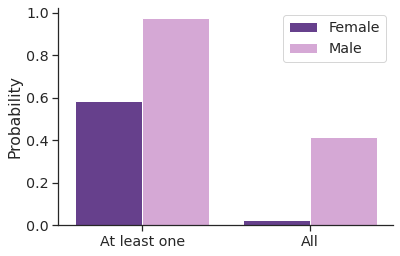

In [16]:
data = {'Prob': [p_atleast_f, 1 - p_atleast_m, p_atleast_m, 1 - p_atleast_f], 
        'Gender': ['Female', 'Female', 'Male', 'Male'],
       'Pos': ['At least one', 'All', 'At least one', 'All']}


df_plot = pd.DataFrame(data=data)

ax = sns.barplot(x="Pos",  y="Prob", data=df_plot,  hue = 'Gender', ci = None, palette=['rebeccapurple', 'plum'])

ax.set(xlabel='', ylabel='Probability')
plt.gca().legend().set_title('')

sns.despine()

plt.savefig('./Figures/descriptive_stats_atleast1_all.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/descriptive_stats_atleast1_all.png',dpi = 300, bbox_inches="tight")

#### in between: Overall frequency of female / male authors

Probability that a paper with x author(s) has at least 1 female author:
x=1: p= 0.236 ;   x=2: p= 0.416 ;   x=3: p= 0.553 ;   p=10: p= 0.932
Probability that a paper with x author(s) has only female authors:
x=1: p= 0.236 ;   x=2: p= 0.055 ;   x=3: p= 0.013 ;   p=10: p= 0.0
[1118, 3762, 3766, 3306, 2171, 1473, 918, 556, 340, 229, 141, 91, 70, 49, 39, 28, 14, 11, 17, 8]


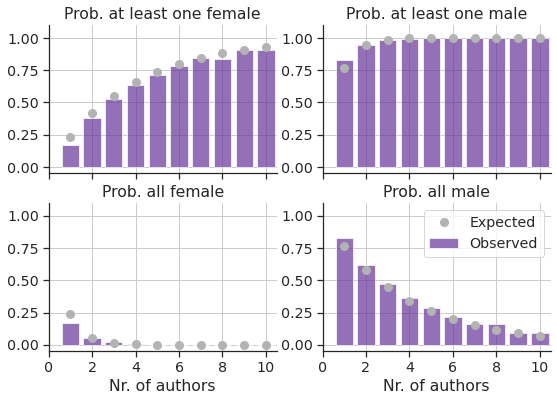

In [102]:


# so if we go by these rough probabilities then...
print("=" * 100)
print("Probability that a paper with x author(s) has at least 1 female author:")
print("x=1: p=", round(1. - p_male_all, 3), ";   x=2: p=", round(1. - p_male_all ** 2, 3),
      ";   x=3: p=", round(1. - p_male_all ** 3, 3), ";   p=10: p=", round(1. - p_male_all ** 10, 3))
print("=" * 100)
# and the reverse:
print("Probability that a paper with x author(s) has only female authors:")
print("x=1: p=", round(p_female_all, 3), ";   x=2: p=", round(p_female_all ** 2, 3),
      ";   x=3: p=", round(p_female_all ** 3, 3), ";   p=10: p=", round(p_female_all ** 10, 3))
# etc
print("=" * 100)
#==================================



# Compute theoretical probabilities of having all male / all female / 1 male / 1 female author(s)
#==================================

n_authors = range(1, 21)
p_one_f_given_n = 1. - p_male_all ** n_authors
p_one_m_given_n = 1. - p_female_all ** n_authors

p_all_f_given_n = p_female_all ** n_authors
p_all_m_given_n = p_male_all ** n_authors


# UGLY CODE below. Please fix if you are inspired
n_authors_data = df.Number_authors.unique()
n_authors_data.sort()

p_atleast_f_per_n = []
p_atleast_m_per_n = []
p_all_f_per_n = []
p_all_m_per_n = []
p_atleast_f_per_n_binary = []
p_atleast_m_per_n_binary = []
p_all_f_per_n_binary = []
p_all_m_per_n_binary = []

nr_papers_n = []
n_authors_data = n_authors_data[0: 20]
for i in n_authors_data:
    p_atleast_f_per_n.append(df[df.Number_authors == i].Prob_atleast_Fauthor.mean())    
    p_atleast_m_per_n.append(df[df.Number_authors == i].Prob_atleast_Mauthor.mean())
    p_all_f_per_n.append((1. - df[df.Number_authors == i].Prob_atleast_Mauthor).mean())
    p_all_m_per_n.append((1. - df[df.Number_authors == i].Prob_atleast_Fauthor).mean())
    
    p_atleast_f_per_n_binary.append(df[df.Number_authors == i].Prob_atleast_Fauthor_binary.mean())    
    p_atleast_m_per_n_binary.append(df[df.Number_authors == i].Prob_atleast_Mauthor_binary.mean())
    p_all_f_per_n_binary.append((1. - df[df.Number_authors == i].Prob_atleast_Mauthor_binary).mean())
    p_all_m_per_n_binary.append((1. - df[df.Number_authors == i].Prob_atleast_Fauthor_binary).mean())
    
    nr_papers_n.append(len(df[df.Number_authors == i])) 
# End ugly crap code
#==================================
    

# plot 
#==================================

plt.figure(figsize=(9, 6))
ax = plt.subplot(221)
plt.bar(n_authors_data, p_atleast_f_per_n, color="rebeccapurple", alpha=0.7)
#plt.bar(n_authors_data, p_atleast_f_per_n_binary, color="lightskyblue", alpha=0.7)
plt.plot(n_authors, p_one_f_given_n, "o", color="0.7", markersize=8)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.05, 1.1)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Prob. at least one female")
#plt.legend(["Expected", "Observed"], loc=4)#, "Data (binary)"
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(222)
plt.bar(n_authors_data, p_atleast_m_per_n, color="rebeccapurple", alpha=0.7)
#plt.bar(n_authors_data, p_atleast_m_per_n_binary, color="salmon", alpha=0.7)
plt.plot(n_authors, p_one_m_given_n, "o", color="0.7", markersize=8)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.05, 1.1)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Prob. at least one male")
#plt.legend(["Expected", "Observed"], loc=4)#,"Data (binary)"


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(223)
plt.bar(n_authors_data, p_all_f_per_n, color="rebeccapurple", alpha=0.7)
#plt.bar(n_authors_data, p_all_f_per_n_binary, color="lightskyblue", alpha=0.7)
plt.plot(n_authors, p_all_f_given_n, "o", color="0.7", markersize=8)
plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.05, 1.1)
plt.xticks([i for i in range(0, 11, 2)], [i for i in range(0, 11, 2)])
plt.title("Prob. all female")
#plt.legend(["Expected", "Observed"])#,"Data (binary)"])
plt.xlabel("Nr. of authors")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax  = plt.subplot(224)
plt.bar(n_authors_data, p_all_m_per_n, color="rebeccapurple", alpha=0.7)
#plt.bar(n_authors_data, p_all_m_per_n_binary, color="salmon", alpha=0.7)
plt.plot(n_authors, p_all_m_given_n, "o", color="0.7", markersize=8)
plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.05, 1.1)
plt.xticks([i for i in range(0, 11, 2)], [i for i in range(0, 11, 2)])
plt.title("Prob. all male")
plt.legend(["Expected", "Observed"])#,"Data (binary)"])
plt.xlabel("Nr. of authors")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('./Figures/Atleast1_all_perNumAuthor.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_all_perNumAuthor.png',dpi = 300, bbox_inches="tight")
print(nr_papers_n)

#### plot biases to better understand the figures above

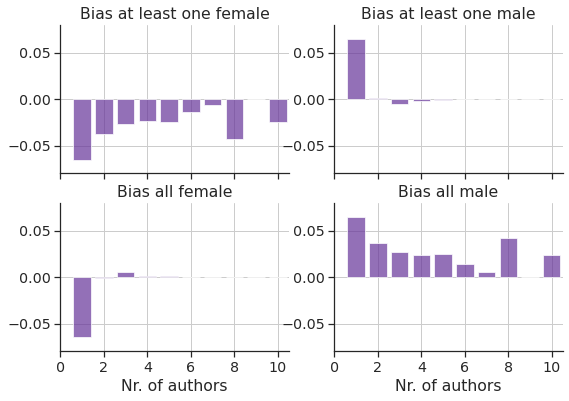

In [19]:
plt.figure(figsize=(9, 6))
ax = plt.subplot(221)
#plt.bar(n_authors_data,  p_atleast_f_per_n_binary - 100*p_one_f_given_n,color="palegreen")
plt.bar(n_authors_data,  p_atleast_f_per_n - p_one_f_given_n, color="rebeccapurple",alpha=0.7)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.08, 0.08)

#plt.legend(["Binary", "Prob."])
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias at least one female")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(222)
#plt.bar(n_authors_data, p_atleast_m_per_n_binary - 100*p_one_m_given_n, color="palegreen")
plt.bar(n_authors_data, p_atleast_m_per_n - p_one_m_given_n, color="rebeccapurple",alpha=0.7)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.08, 0.08)

#plt.legend(["Binary", "Prob."])
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias at least one male")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(223)
#plt.bar(n_authors_data,  p_all_f_per_n_binary - 100*p_all_f_given_n, color="palegreen")
plt.bar(n_authors_data,  p_all_f_per_n - p_all_f_given_n, color="rebeccapurple",alpha=0.7)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.08, 0.08)

plt.xticks([i for i in range(0, 11, 2)], [i for i in range(0, 11, 2)])
#plt.legend(["Binary", "Prob."], loc=4)
plt.xlabel("Nr. of authors")
plt.title("Bias all female")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(224)
#plt.bar(n_authors_data, p_all_m_per_n_binary - 100*p_all_m_given_n, color="palegreen")
plt.bar(n_authors_data, p_all_m_per_n - p_all_m_given_n, color="rebeccapurple",alpha=0.7)

plt.grid()
plt.xlim(0, 10.5)
plt.ylim(-0.08, 0.08)
plt.xticks([i for i in range(0, 11, 2)], [i for i in range(0, 11, 2)])
#plt.legend(["Binary", "Prob."], loc=4)
plt.xlabel("Nr. of authors")

plt.title("Bias all male")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig("bias_with_binary.png", dpi=300)

plt.savefig('./Figures/Bias_Atleast1_all_perNumAuthor.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Bias_Atleast1_all_perNumAuthor.png',dpi = 300, bbox_inches="tight")

In [20]:
mean_articles = df['Number_authors'].sum()/df.shape[0]

print('Average number of authors for articles', mean_articles)

Average number of authors for articles 4.231349862258953


In [24]:
(p_atleast_f_per_n[0:6] - p_one_f_given_n[0:6]).sum()/6

-0.03190600813809841

#### We can compute the same quantity per each journal

In [89]:

journals = df['journal'].unique() # a list of unique journal names


for i in journals: #update values for each journal
    cond = df['journal']==i
    print("N = ", len(df[cond].values), " for journal ", i)
    df.loc[cond,'P_atleast_F_journal'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_journal'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_first_F_journal'] = df.loc[cond,'First_Author_probF'].sum()/df[cond].shape[0]
    df.loc[cond,'P_last_F_journal'] = df.loc[cond,'Last_Author_probF'].sum()/df[cond].shape[0]
    df.loc[cond,'Number_authors_journal'] = df.loc[cond,'Number_authors'].mean()


    cond = df_co['journal']==i
    n_coauthors =df_co[cond].Number_authors.sum() - 2*df_co[cond].shape[0]

    # Sum of probability of female / total nr. 
    df_co.loc[cond,'P_coauthor_F_journal'] = df_co[cond].apply(lambda x: Prob_coauthor(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / n_coauthors


    

N =  2024  for journal  BSSA
N =  3308  for journal  GJI
N =  1753  for journal  GEOPHYSICS
N =  2022  for journal  GRL
N =  3027  for journal  JGRSolidEarth
N =  1606  for journal  Tectp
N =  78  for journal  Science
N =  1239  for journal  EPSL
N =  458  for journal  PEPI
N =  736  for journal  G3
N =  219  for journal  SolidEarth
N =  1452  for journal  SRL
N =  169  for journal  NatureGeoscience
N =  59  for journal  Nature


##### Make bar plots

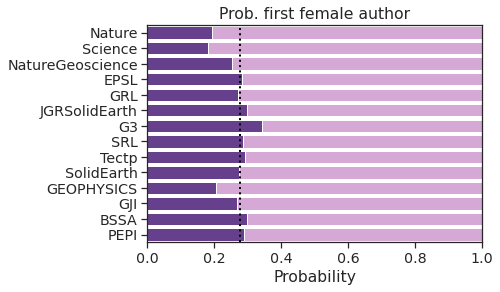

In [25]:
dict_IF =  ['Nature', 'Science', 'NatureGeoscience', 'EPSL', 'GRL', 
        'JGRSolidEarth', 'G3', 'SRL', 'Tectp', 'SolidEarth', 
       'GEOPHYSICS', 'GJI', 'BSSA', 'PEPI']

ax = sns.barplot(y="journal", x="First_Author_probF",  data=df, estimator = sum, order=dict_IF, color = 'plum',capsize=.2, errwidth = 2,
                ci = None)
sns.barplot(y="journal", x="First_Author_probF",  data=df, order=dict_IF, color = 'rebeccapurple',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])

ax.axvline(p_ff, ls=':', color = 'black', lw = '2.')  #a line in the overall value

ax.set(xlabel='Probability', ylabel='')
ax.set_title('Prob. first female author')

plt.savefig('./Figures/First_f_perJournal.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/First_f_perJournal.png',dpi = 300, bbox_inches="tight")

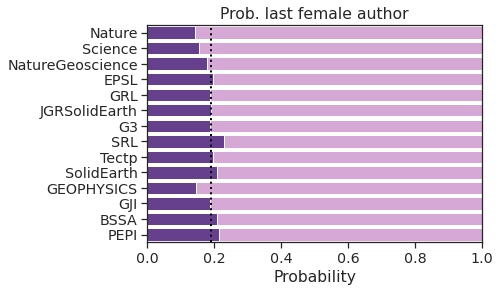

In [26]:
ax = sns.barplot(y="journal", x="Last_Author_probF",  data=df, estimator = sum, order=dict_IF, color = 'plum',capsize=.2, errwidth = 2,
                ci = None)
sns.barplot(y="journal", x="Last_Author_probF",  data=df, order=dict_IF, color = 'rebeccapurple',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])

ax.axvline(p_fl, ls=':', color = 'black', lw = '2.')  #a line in the overall value

ax.set(xlabel='Probability', ylabel='')
ax.set_title('Prob. last female author')

plt.savefig('./Figures/Last_f_perJournal.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Last_f_perJournal.png',dpi = 300, bbox_inches="tight")

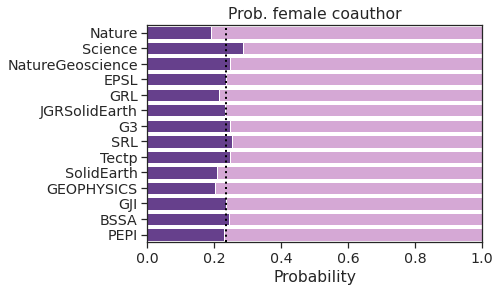

In [29]:
ax = sns.barplot(y="journal", x="P_coauthor_F_journal",  data=df_co, estimator = sum, order=dict_IF, color = 'plum',capsize=.2, errwidth = 2,
                ci = None)
sns.barplot(y="journal", x="P_coauthor_F_journal",  data=df_co, order=dict_IF, color = 'rebeccapurple',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])

ax.axvline(p_female_all_co, ls=':', color = 'black', lw = '2.')  #a line in the overall value

ax.set(xlabel='Probability', ylabel='')
ax.set_title('Prob. female coauthor')

plt.savefig('./Figures/Coauthor_f_perJournal.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Coauthor_f_perJournal.png',dpi = 300, bbox_inches="tight")

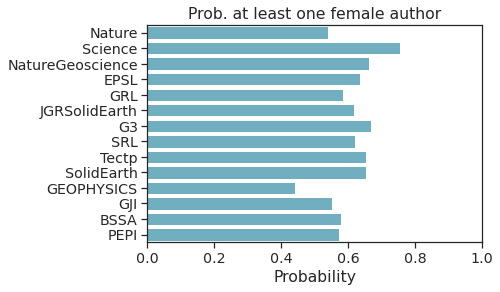

In [99]:
dict_IF =  ['Nature', 'Science', 'NatureGeoscience', 'EPSL', 'GRL', 
        'JGRSolidEarth', 'G3', 'SRL', 'Tectp', 'SolidEarth', 
       'GEOPHYSICS', 'GJI', 'BSSA', 'PEPI']

order = df.sort_values('Number_authors_journal')['journal'].unique()



p_one_f = 1. - p_male_all ** (df.sort_values('Number_authors_journal')['Number_authors_journal'])
points_df = pd.DataFrame({'Prob': p_one_f, 
                          'journal': df.sort_values('Number_authors_journal')['journal']})

ax = sns.barplot(y="journal", x="Prob_atleast_Fauthor",  data=df, order=dict_IF, color = 'c',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])

#sns.scatterplot(y = 'journal', x = 'Prob', data=points_df, legend=False, zorder=10, color = 'slategray')

ax.set(xlabel='Probability', ylabel='')
ax.set_title('Prob. at least one female author')

plt.savefig('./Figures/Atleast1_f_perJournal_orderIF.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_f_perJournal_orderIF.png',dpi = 300, bbox_inches="tight")

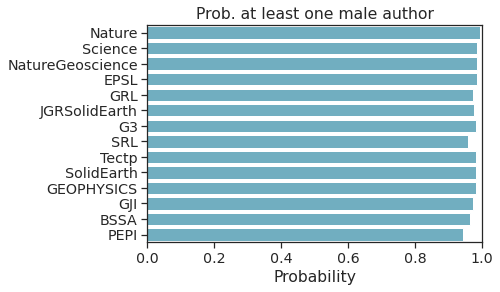

In [100]:
ax = sns.barplot(y="journal", x="Prob_atleast_Mauthor",  data=df, order=dict_IF, color = 'c',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])



p_one_m = 1. - p_female_all ** (df.sort_values('Number_authors_journal')['Number_authors_journal'])
points_df = pd.DataFrame({'Prob': p_one_m, 
                          'journal': df.sort_values('Number_authors_journal')['journal']})



#sns.scatterplot(y = 'journal', x = 'Prob', data=points_df, legend=False, zorder=10, color = 'slategray')

ax.set(xlabel='Probability', ylabel='')
ax.set_title('Prob. at least one male author')

plt.savefig('./Figures/Atleast1_m_perJournal_orderIF.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_m_perJournal_orderIF.png',dpi = 300, bbox_inches="tight")

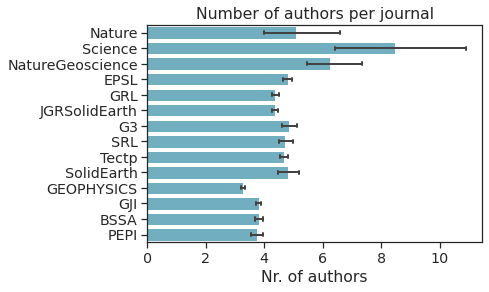

In [96]:
ax = sns.barplot(y="journal", x="Number_authors",  data=df,estimator = np.mean, order=dict_IF, 
                 color = 'c', ci= 95, capsize=.2, errwidth = 2)

#plt.xlim([0,1])



ax.set(xlabel='Nr. of authors', ylabel='')
ax.set_title('Number of authors per journal')

plt.savefig('./Figures/NumAuthors_perJournal_orderIF.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/NumAuthors_perJournal_orderIF.png',dpi = 300, bbox_inches="tight")

(0.7970836047776952, 0.0006407207522560931)

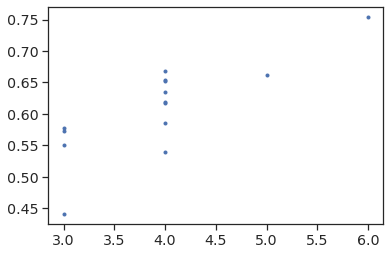

In [54]:
tmp = df[['journal','IF','Number_authors_journal','P_atleast_F_journal',
          'P_atleast_M_journal']].groupby(['journal']).mean()


plt.plot(tmp.Number_authors_journal, tmp.P_atleast_F_journal,'.')
stats.pearsonr(tmp.Number_authors_journal, tmp.P_atleast_F_journal)

(0.4619134410698794, 0.09635469014528998)

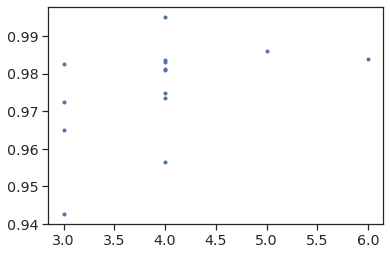

In [53]:
plt.plot(tmp.Number_authors_journal, tmp.P_atleast_M_journal,'.')
stats.pearsonr(tmp.Number_authors_journal, tmp.P_atleast_M_journal)

SpearmanrResult(correlation=0.7054945054945055, pvalue=0.004819557979048519)

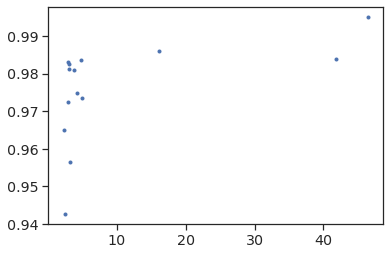

In [55]:
plt.plot(tmp.IF, tmp.P_atleast_M_journal,'.')
stats.spearmanr(tmp.IF, tmp.P_atleast_M_journal)

SpearmanrResult(correlation=0.2967032967032967, pvalue=0.30296672383870205)

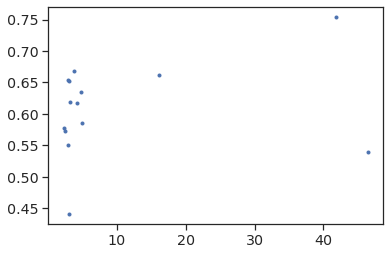

In [56]:
plt.plot(tmp.IF, tmp.P_atleast_F_journal,'.')
stats.spearmanr(tmp.IF, tmp.P_atleast_F_journal)

#### Plot bar plots for fixed number of authors

In [97]:
## Gather all high impact journals together to increase number of papers in bin

df['journal2'] = df['journal']
df.loc[df['journal2'] == 'Nature','journal2'] = 'Nat/Sci/NatGeo' 
df.loc[df['journal2'] == 'Science','journal2'] = 'Nat/Sci/NatGeo' 
df.loc[df['journal2'] == 'NatureGeoscience','journal2'] = 'Nat/Sci/NatGeo' 

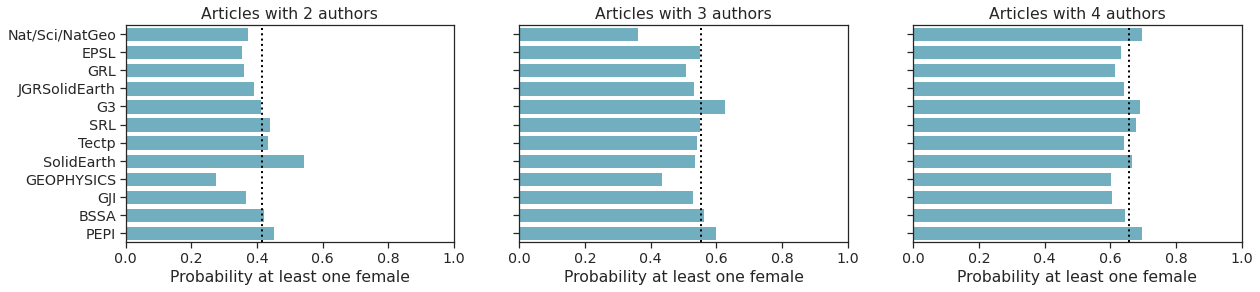

In [103]:
dict_IF = ['Nat/Sci/NatGeo', 'EPSL', 'GRL', 
        'JGRSolidEarth', 'G3', 'SRL', 'Tectp', 'SolidEarth', 
       'GEOPHYSICS', 'GJI', 'BSSA', 'PEPI']



plt.figure(figsize=(20, 4))


plt.subplot(131)

ax = sns.barplot(y="journal2", x="Prob_atleast_Fauthor",  data=df[df.Number_authors == 2],
                order=dict_IF, color='c', ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one female', ylabel='')
ax.set_title('Articles with 2 authors')

ax.axvline(p_one_f_given_n[1], ls=':', color = 'black', lw = '2.') #a line in the expected value

plt.subplot(132)

ax = sns.barplot(y="journal2", x="Prob_atleast_Fauthor",  data=df[df.Number_authors == 3],
                 order=dict_IF, color='c',ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one female', ylabel='')
ax.set(ylabel=None)
ax.set(yticklabels=[])  # remove the tick labels
ax.set_title('Articles with 3 authors')

ax.axvline(p_one_f_given_n[2], ls=':', color = 'black', lw = '2.')  #a line in the expected value

plt.subplot(133)

ax = sns.barplot(y="journal2", x="Prob_atleast_Fauthor",  data=df[df.Number_authors == 4],
                 order=dict_IF, color='c',ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one female', ylabel='')
ax.set_title('Articles with 4 authors')

ax.set(ylabel=None)
ax.set(yticklabels=[])  # remove the tick labels

ax.axvline(p_one_f_given_n[3], ls=':', color = 'black', lw = '2.')  #a line in the expected value


plt.savefig('./Figures/Atleast1_f_perJournal_fixedNumAut.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_f_perJournal_fixedNumAut.png',dpi = 300, bbox_inches="tight")


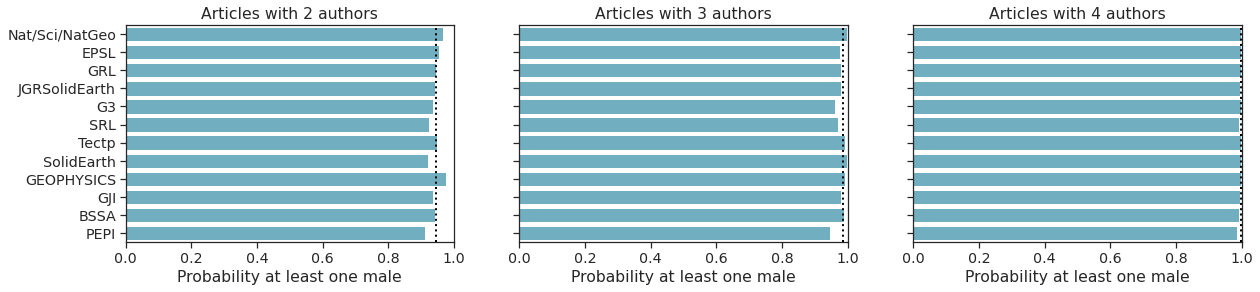

In [104]:
plt.figure(figsize=(20, 4))


plt.subplot(131)

ax = sns.barplot(y="journal2", x="Prob_atleast_Mauthor",  data=df[df.Number_authors == 2],
                order=dict_IF, color='c', ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one male', ylabel='')
ax.set_title('Articles with 2 authors')

ax.axvline(p_one_m_given_n[1], ls=':', color = 'black', lw = '2.') #a line in the expected value

plt.subplot(132)

ax = sns.barplot(y="journal2", x="Prob_atleast_Mauthor",  data=df[df.Number_authors == 3],
                 order=dict_IF, color='c',ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one male', ylabel='')
ax.set(ylabel=None)
ax.set(yticklabels=[])  # remove the tick labels
ax.set_title('Articles with 3 authors')

ax.axvline(p_one_m_given_n[2], ls=':', color = 'black', lw = '2.') #a line in the expected value

plt.subplot(133)

ax = sns.barplot(y="journal2", x="Prob_atleast_Mauthor",  data=df[df.Number_authors == 4],
                 order=dict_IF, color='c',ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability at least one male', ylabel='')
ax.set_title('Articles with 4 authors')

ax.set(ylabel=None)
ax.set(yticklabels=[])  # remove the tick labels

ax.axvline(p_one_m_given_n[3], ls=':', color = 'black', lw = '2.') #a line in the expected value

plt.savefig('./Figures/Atleast1_m_perJournal_fixedNumAut.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_m_perJournal_fixedNumAut.png',dpi = 300, bbox_inches="tight")


#### I don't think there is a particularly strong effect of impact factor? It is hard to tell because n is small for Nature etc... overall we just see that female authors have more difficulty to be in predominantly male papers, than male authors to be in predominantly female papers, and that there seems to be a homophily effect jejejeje


#### See the temporal trend of having at least one F or one M in a publication for all journals per year


In [105]:
years = df['year'].unique() # a list of unique journal names
years.sort()
print(years)

for i in years: #update values for each journal
    cond = df['year']==i
    print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_atleast_F_year'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_year'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'Number_authors_year'] = df.loc[cond,'Number_authors'].mean()
    
    cond = df_co['year']==i
    n_coauthors =df_co[cond].Number_authors.sum() - 2*df_co[cond].shape[0]

    # Sum of probability of female / total nr. 
    df_co.loc[cond,'P_coauthor_F_year'] = df_co[cond].apply(lambda x: Prob_coauthor(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / n_coauthors




['2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020']
Number of articles =  1317  for year  2010
Number of articles =  1266  for year  2011
Number of articles =  1260  for year  2012
Number of articles =  1600  for year  2013
Number of articles =  1593  for year  2014
Number of articles =  1634  for year  2015
Number of articles =  1770  for year  2016
Number of articles =  1687  for year  2017
Number of articles =  1958  for year  2018
Number of articles =  1819  for year  2019
Number of articles =  2246  for year  2020


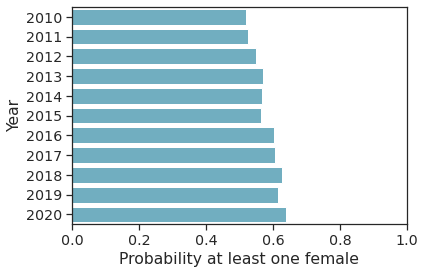

In [106]:
ax = sns.barplot(y="year", x="Prob_atleast_Fauthor",  data=df, order=years, color='c', capsize=.2, errwidth = 2,
                ci = None)
ax.set(xlabel='Probability at least one female', ylabel='Year')
plt.xlim([0,1])

plt.savefig('./Figures/Atleast1_f_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_f_perYear.png',dpi = 300, bbox_inches="tight")

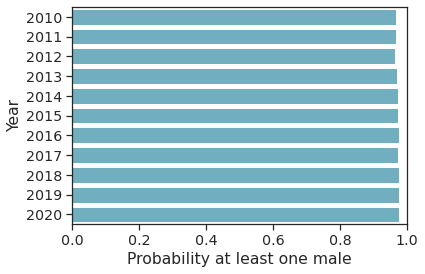

In [107]:
ax = sns.barplot(y="year", x="Prob_atleast_Mauthor",  data=df, order=years, color='c',capsize=.2, errwidth = 2,
                ci = None)
ax.set(xlabel='Probability at least one male', ylabel='Year')

plt.xlim([0,1])

plt.savefig('./Figures/Atleast1_m_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Atleast1_m_perYear.png',dpi = 300, bbox_inches="tight")

#### Female & male first and last authorship probabilities per year 

In [108]:
for i in years: #update values for each journal
    cond = (df['year']==i) 
    # alternatively: Do not remove Init and then probabilities do not sum to 1.
    # cond = df['year']==i
    
    print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_first_F_year'] = df.loc[cond,'First_Author_probF'].sum() / len(df.loc[cond])
    df.loc[cond,'P_first_M_year'] = (1. - df.loc[cond,'First_Author_probF']).sum() / len(df.loc[cond])
    
    # uncomment the following line to check if sums up to 1
    # print(df.loc[cond, "P_first_F_year"].iloc[0:5] + df.loc[cond, "P_first_M_year"].iloc[0:5])
    print("Probability that first author is female: ", df.loc[cond, "P_first_F_year"].iloc[0])
    print("Probability that first author is male: ", df.loc[cond, "P_first_M_year"].iloc[0])

    
    # last author
    cond = (df['year']==i) 
    # alternatively: Do not remove Init and then probabilities do not sum to 1.
    # cond = df['year']==i
    
    #print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_last_F_year'] = df.loc[cond,'Last_Author_probF'].sum() / len(df.loc[cond])
    df.loc[cond,'P_last_M_year'] = (1. - df.loc[cond,'Last_Author_probF']).sum() / len(df.loc[cond])
    
    # uncomment the following line to check if sums up to 1
    # print(df.loc[cond, "P_last_F_year"].iloc[0:5] + df.loc[cond, "P_last_M_year"].iloc[0:5])
    print("Probability that last author is female: ", df.loc[cond, "P_last_F_year"].iloc[0])
    print("Probability that last author is male: ", df.loc[cond, "P_last_M_year"].iloc[0])

df.to_csv("analysis_output_" + time.strftime("%Y-%m-%d.csv"))

Number of articles =  1317  for year  2010
Probability that first author is female:  0.2536917222738813
Probability that first author is male:  0.7463082777261187
Probability that last author is female:  0.17735285195891848
Probability that last author is male:  0.8226471480410815
Number of articles =  1266  for year  2011
Probability that first author is female:  0.2574419327710795
Probability that first author is male:  0.7425580672289206
Probability that last author is female:  0.18363585834459867
Probability that last author is male:  0.8163641416554013
Number of articles =  1260  for year  2012
Probability that first author is female:  0.2717478995004285
Probability that first author is male:  0.7282521004995716
Probability that last author is female:  0.18369951639788049
Probability that last author is male:  0.8163004836021195
Number of articles =  1600  for year  2013
Probability that first author is female:  0.28021160498755576
Probability that first author is male:  0.7197883

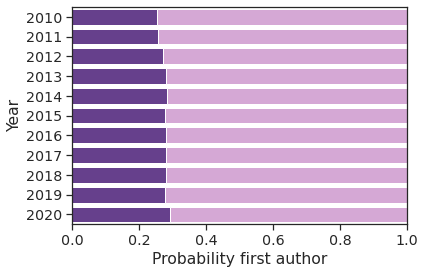

In [109]:


ax = sns.barplot(y="year", x="First_Author_probF",  data=df, estimator = sum, order=years, color = 'plum')
sns.barplot(y="year", x="First_Author_probF", data=df, ci=None,  order=years, color='rebeccapurple',dodge = False,
           capsize=.2, errwidth = 2)
ax.set(xlabel='Probability first author', ylabel='Year')
plt.xlim([0,1])

patches = ax.patches
lines_per_err = 3

for i, line in enumerate(ax.get_lines()):
    line.set_color('white')


plt.savefig('./Figures/FirstAuthor_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/FirstAuthor_perYear.png',dpi = 300, bbox_inches="tight")


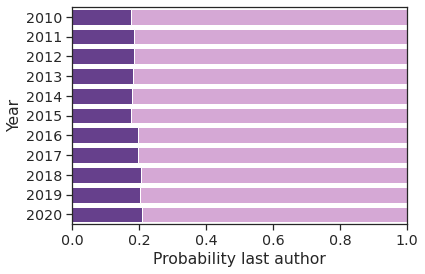

In [110]:

ax = sns.barplot(y="year", x="Last_Author_probF",  data=df, estimator = sum, order=years, color = 'plum')
sns.barplot(y="year", x="Last_Author_probF", data=df, ci=None,  order=years, color='rebeccapurple',dodge = False,
            capsize=.2, errwidth = 2)
ax.set(xlabel='Probability last author', ylabel='Year')
plt.xlim([0,1])

patches = ax.patches
lines_per_err = 3

for i, line in enumerate(ax.get_lines()):
    line.set_color('white')

plt.savefig('./Figures/LastAuthor_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/LastAuthor_perYear.png',dpi = 300, bbox_inches="tight")

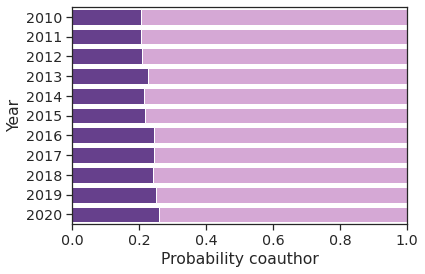

In [111]:
ax = sns.barplot(y="year", x="P_coauthor_F_year",  data=df_co, estimator = sum, order=years, color = 'plum',capsize=.2, errwidth = 2,
                ci = None)
sns.barplot(y="year", x="P_coauthor_F_year",  data=df_co, order=years, color = 'rebeccapurple',capsize=.2, errwidth = 2,
                ci = None)
plt.xlim([0,1])

ax.set(xlabel='Probability coauthor', ylabel='Year')
ax.set_title('')

plt.savefig('./Figures/Coauthor_f_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/Coauthor_f_perYear.png',dpi = 300, bbox_inches="tight")

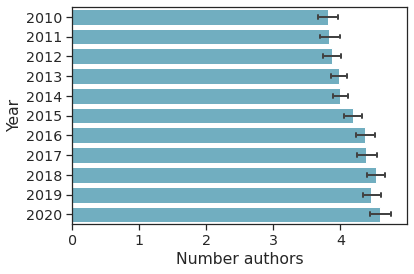

In [116]:

ax = sns.barplot(y="year", x="Number_authors", data=df, ci=95, estimator = np.mean, order=years, color='c',dodge = False,
            capsize=.2, errwidth = 2)
ax.set(xlabel='Number authors', ylabel='Year')


plt.savefig('./Figures/NumberAuthors_f_perYear.pdf',dpi = 300, bbox_inches="tight")
plt.savefig('./Figures/NumberAuthors_f_perYear.png',dpi = 300, bbox_inches="tight")

#### Rates of change in participation of female authors per year


In [119]:
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(df.year.values.astype('float'),df.P_first_F_year.values)

print('Pearson correlation coefficients and increasing rate:')
print('\n')

print('Correlation between first female and year (r,p-value):', r_value_1, p_value_1)
print('Increasing rate first female per year (%):', slope_1*100)


slope_l, intercept_l, r_value_l, p_value_l, std_err_l = stats.linregress(df.year.values.astype('float'),df.P_last_F_year.values)

print('\n')
print('Correlation between last female and year (r,p-value):', r_value_l, p_value_l)
print('Increasing rate last female per year (%):', slope_l*100)

slope_co, intercept_co, r_value_co, p_value_co, std_err_co = stats.linregress(df_co.year.astype('float').unique(),df_co.P_coauthor_F_year.unique())

print('\n')
print('Correlation between coauthor female and year (r,p-value):', r_value_co, p_value_co)
print('Increasing rate coauthor female per year (%):', slope_co*100)


slope_au, intercept_au, r_value_au, p_value_au, std_err_au = stats.linregress(df.year.astype('float').unique(),df.Number_authors_year.unique())

print('\n')
print('Correlation between number of authors and year (r,p-value):', r_value_au, p_value_au)
print('Increasing rate number of authors per year (%):', slope_au*100)



slope_alf, intercept_alf, r_value_alf, p_value_alf, std_err_alf = stats.linregress(df.year.astype('float').unique(),df.P_atleast_F_year.unique())

print('\n')
print('Correlation between prob. at least one female author and year (r,p-value):', r_value_alf, p_value_alf)
print('Increasing rate prob. at least one female author per year (%):', slope_alf*100)

slope_alm, intercept_alm, r_value_alm, p_value_alm, std_err_alm = stats.linregress(df.year.astype('float').unique(),df.P_atleast_M_year.unique())

print('\n')
print('Correlation between prob. at least one male author and year (r,p-value):', r_value_alm, p_value_alm)
print('Increasing rate prob. at least one male author per year (%):', slope_alm*100)


Pearson correlation coefficients and increasing rate:


Correlation between first female and year (r,p-value): 0.8077241200143462 0.0
Increasing rate first female per year (%): 0.2708148742558028


Correlation between last female and year (r,p-value): 0.8626965192071899 0.0
Increasing rate last female per year (%): 0.32829379059054087


Correlation between coauthor female and year (r,p-value): 0.9450693304253721 1.1536358151636113e-05
Increasing rate coauthor female per year (%): 0.5555888587861866


Correlation between number of authors and year (r,p-value): 0.977052939498836 2.3787869447722298e-07
Increasing rate number of authors per year (%): 8.731112616350249


Correlation between prob. at least one female author and year (r,p-value): 0.9708851108979674 6.882225299866314e-07
Increasing rate prob. at least one female author per year (%): 1.1918126898335615


Correlation between prob. at least one male author and year (r,p-value): 0.8748991533402276 0.00042210730250351374
Increasing



Linear trends are statistically significant. 

The rates of increase per year are weirdly consistent for first and last author: 0.271 % for first authors and 0.328 % for last authors. For coauthors, is almost twice faster the incres: 0.556%

# when would seismology reach parity?

In [128]:
year_parity_first = (0.5 - intercept_1) / slope_1
print('Female and male first authorship will be equally likely in', year_parity_first - 2020, 'years')

year_parity_last = (0.5 - intercept_l) / slope_l
print('Female and male last authorship will be equally likely in', year_parity_last - 2020, 'years')

year_parity_last = (0.5 - intercept_co) / slope_co
print('Female and male coauthorship will be equally likely in', year_parity_last - 2020, 'years')

year_parity_last = (0.98 - intercept_alf) / slope_alf
print('Female coauthors will appear in all papers in', year_parity_last - 2020, 'years')

year_parity_last = (0.98 - intercept_alm) / slope_alm
print('Male coauthors will appear in all papers in', year_parity_last - 2020, 'years')

Female and male first authorship will be equally likely in 77.6114522756543 years
Female and male last authorship will be equally likely in 89.47844336944036 years
Female and male coauthorship will be equally likely in 43.66503385666465 years
Female coauthors will appear in all papers in 28.544584334345473 years
Male coauthors will appear in all papers in 1.3741962545132083 years


# Oh...in just about 80 - 90 years! 
While the rate of increase in last authorship is ever so slightly higher, the level of last authorships is lower to begin with, so to reach parity will take a bit longer.